# Language Modeling

one of the biggest reasons to do language modeling is to **learn effective, vector representations of the words in our vocabulary**.

These representations, or word embeddings, capture the inherent distribution of words in commonly occuring language by mapping words or phrases to a corresponding vector of real numbers (hence the name, word2vec). There are several advantages of having these vector representations:
- They are easier for a model to digest 
- They capture more contextual information in a lower dimensional space (compared to say, the bag of words approach)

Visualizing some word-vector representations in a scatter plot (of arbitrary vocabulary):
<img src="https://drive.google.com/uc?export=view&id=1k7shuS9Kig5ilZ2a1dHoQEQ44fRYmKWC
" height="550" width="900">

The hope is by observing what words occur together, we can extract some notion of *meaning* with our word embeddings. We can then transfer these meaningful embeddings across different tasks, to accelerate learning. 

Each word in our vocabulary is assigned a unique word embedding, which is essentially a feature vector, such that **words that are semantically similar will be assigned word embeddings that are nearby in our word embedding feature space**. 

Here, we'll create a specific model for learning & creating word embeddings: the **Skipgram Model**.

## Loading a Simple Corpus ##

Make sure `corpus.txt` exists in your own Drive/Folder. You may need to change the path for the corpus, or you will get a "No such file or directory" error.
Run the following code to load in the corpus and print the first 10 sentences.

In [1]:
# Load Corpus
from google.colab import drive 
drive.mount('/content/drive', force_remount=True) 

# This is the file path for TAs. Students will have to make a copy and then put in the file path themselves.
with open('/content/drive/My Drive/Colab Notebooks/Tutorials/corpus.txt', 'r') as f:
  sentences = f.read().split('.\n')
    
# Print the first 10 sentences
for s in sentences[:10]: 
    print(s)

Mounted at /content/drive
John travelled to the hallway 
Mary journeyed to the bathroom 
John travelled to the hallway 
Mary journeyed to the bathroom 
Daniel went back to the bathroom 
John moved to the bedroom 
John travelled to the hallway 
Mary journeyed to the bathroom 
Daniel went back to the bathroom 
John moved to the bedroom 


## What are Skipgrams? ##

Recall our goal: we want word embeddings that effectively capture *meaning* of words. What does *meaning* actually *mean*?

Consider the following sentences: 

`"The quick brown fox jumps over the lazy dog."` <br>
`"The lazy dog jumps over the quick brown fox."` <br>
`"The quick fox jumps over the lazy brown fox." ` <br>

Let's assume we didn't know anything about language, or what any of these words mean. Looking at individual words, we can't glean much meaning. However, **in context** we might be able to learn how certain words operate. 

Consider the words "quick" and "lazy" in the above sentences. We see they occur near one of "fox" or "dog" and perhaps can conclude they are modifiers for "fox" or "dog". 

If we had more and more sentences with "quick" and "lazy", it would become easier and easier to extract meaning from their context.

With Skip-Grams, we model meaning by looking at **windows** of words, essentially looking at a group of words in context. Given a window and a word in that window, our training objective then becomes to predict all the words in the given window.

The following picture demonstrates this windowing method, generating a training set with a window size of 2:

<img src="https://drive.google.com/uc?export=view&id=1xrNYGpBuENYZ1KphnyHooI2xhrl2sYNP">

Given a word in a window, predict all the neighboring words. Given this, let's generate our training data. Note that WINDOW_SIZE is a parameter.

## Generating Skipgrams

In [2]:
# Set window size
WINDOW_SIZE = 2

# Build Vocabulary (word id's)
vocab = set("".join(sentences).split()) # collects all unique words in our dataset (vocab) - 17 words
word2id = {w: i for i, w in enumerate(list(vocab))} # maps each word in our vocab to a unique index (label encode)

# Split sentences into words
s = map(lambda x: x.split(), sentences)

# TODO: Create Skipgram Data => Fill in Question Mark to Check-Off
data = []
for sentence in s:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[(0 if (word_index-WINDOW_SIZE)<0 else word_index-WINDOW_SIZE):min(word_index+WINDOW_SIZE+1, len(sentence))]: 
            if nb_word != word:
                data.append([word2id[word], word2id[nb_word]])
print(len(data))

14608


## Building our Skipgram Model ##

Now that we have all the data processed, we can build our Skip-Gram model. It's really simple and uses a lot of the ideas we've already used so far.

We take as input a single word ID and output another predicted word in the same window. We will need to add an embedding layer. To calculate loss, consider using [sparse_softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Wondering why we are using *sparse_softmax_cross_entropy_with_logits* over *softmax_cross_entropy_with_logits*? Read more [here](https://stackoverflow.com/questions/37312421/whats-the-difference-between-sparse-softmax-cross-entropy-with-logits-and-softm). 

Now, let's code it up, and train our model!

Note that we've provided you with a set `vocabulary size` and `embedding size`.
- **vocabulary size** is  number of unique words in your training corpus. 
- **embedding size** is the dimensionality of your feature space. For each word, we initialize its embedding as a vector of **embedding size** floats, where **embedding size** is the system hyperparameter. 

In general, the larger our embedding size, the more "rich" and semantically meaningful our embedding representation will be. This only holds true up to a certain embedding size though, and there does exist a notion of an "ideal" embedding size. Increasing embedding size past this will only introduce meaningless features (noise) and won't improve the loss or accuracy of your language model. 

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model

# Parameters
VOCAB_SZ = len(word2id) # 17
EMBEDDING_SZ = 30


class W2V(Model):
  # Create Network Weights
  def __init__(self):
    super(W2V, self).__init__()
    self.E = tf.Variable(tf.random.normal([VOCAB_SZ, EMBEDDING_SZ], stddev=.1))
    self.W = tf.Variable(tf.random.normal([EMBEDDING_SZ, VOCAB_SZ], stddev=.1))
    self.b = tf.Variable(tf.random.normal([VOCAB_SZ], stddev=.1))

  # Building Inference Pipeline
  def call(self, inputs):
    embedding = tf.nn.embedding_lookup(self.E, inputs)
    logits = tf.matmul(embedding, self.W) + self.b
    return logits

  # Build Loss 
  def loss_func(self, logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels, logits))

# Optimizer
def run_batch(model, inputs, labels):
  logits = model(inputs)
  loss = model.loss_func(logits, labels)
  return loss
  

## Training ##

To train the model, go through our data in multiple epochs, optimizing the loss as we normally do.

In [4]:
BSZ, EPOCHS = 128, 100
data = np.array(data)

model = W2V()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for ep in range(EPOCHS):
  curr_loss = 0
  step = 0
  for start, end in zip(range(0, len(data) - BSZ, BSZ), range(BSZ, len(data), BSZ)):
    batch_X = data[start:end, 0]
    batch_Y = data[start:end, 1]
    with tf.GradientTape() as tape:
      loss = run_batch(model,batch_X,batch_Y)
    curr_loss += loss
    step += 1
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
  if ep % 10 == 0:
    print('Epoch %d\tLoss: %.3f' % (ep, curr_loss / step))


Epoch 0	Loss: 2.718
Epoch 10	Loss: 1.894
Epoch 20	Loss: 1.886
Epoch 30	Loss: 1.884
Epoch 40	Loss: 1.884
Epoch 50	Loss: 1.883
Epoch 60	Loss: 1.883
Epoch 70	Loss: 1.883
Epoch 80	Loss: 1.883
Epoch 90	Loss: 1.883


## Visualizing Embeddings ###

Run the following code check out some similar words and see what our embeddings look like!

In [5]:
# Load Embeddings, define id2word
embeddings = model.E.read_value()
id2word = {i: w for w, i in word2id.items()}

# Helper Functions:

# Calculate euclidean distance between two vectors
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))

# Return the id of the word with smallest euclidean distance to the queried word(index)
def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [6]:
# Print words
print("List of words:" + "\n" + "\n".join(word2id.keys()))

List of words:
moved
John
the
garden
kitchen
hallway
back
to
Mary
office
journeyed
Daniel
travelled
went
Sandra
bathroom
bedroom


In [8]:
# Put words in the following call to see what's close-by!
print('Closest word:', id2word[find_closest(word2id['back'], embeddings)])
print('Closest word:', id2word[find_closest(word2id['Daniel'], embeddings)])
print('Closest word:', id2word[find_closest(word2id['office'], embeddings)])

Closest word: travelled
Closest word: Mary
Closest word: kitchen


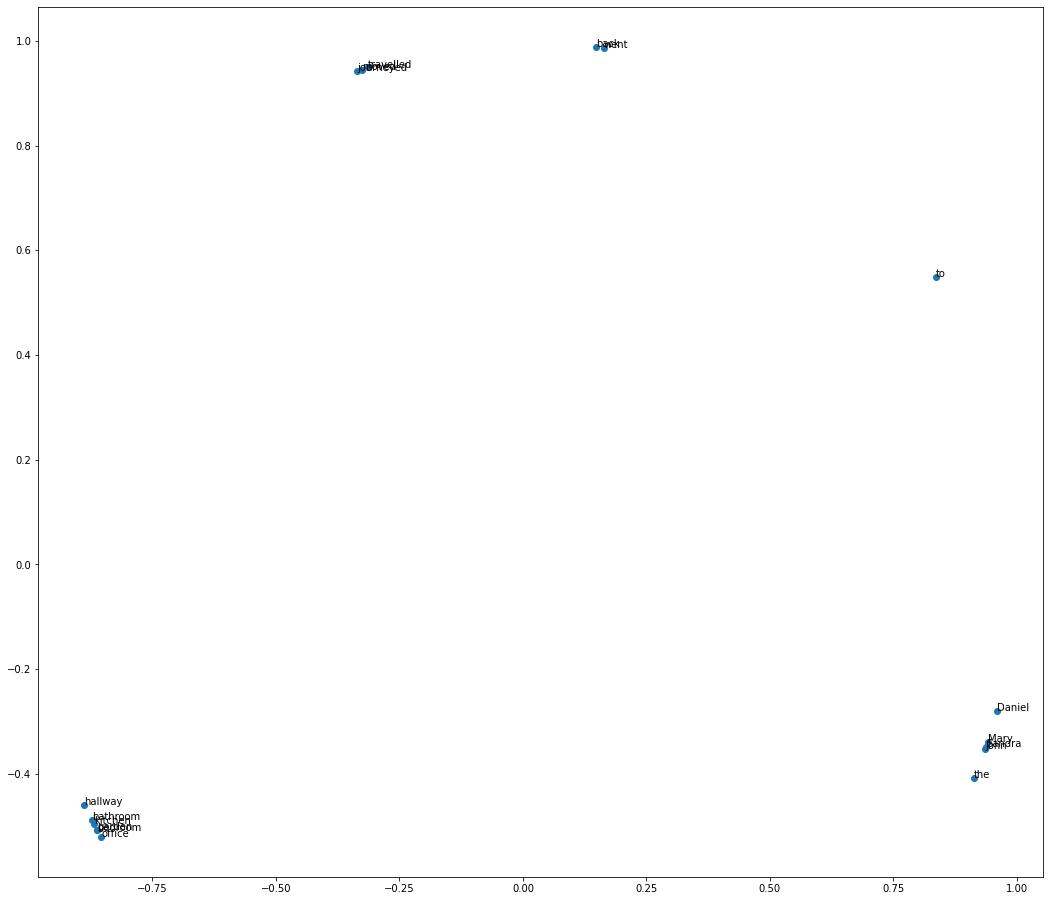

In [11]:
# Visualizing the Embeddings
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

# reduce dimenion from 30 to 2
pca = PCA(n_components=2) # PCA is better than TSNE for large dimension like 30 :)
vectors = pca.fit_transform(embeddings)

# normalize the results so that we can view them more comfortably in matplotlib
normalizer = preprocessing.Normalizer()
norm_vectors = normalizer.fit_transform(vectors, 'l2')

# plot the 2D normalized vectors
x_vec = []
y_vec = []
for x,y in norm_vectors:
  x_vec.append(x)
  y_vec.append(y)
  
f, axs = plt.subplots(1,1,figsize=(18,16))
plt.scatter(x_vec, y_vec)
for word in word2id:
      plt.annotate(word, (norm_vectors[word2id[word]][0], norm_vectors[word2id[word]][1] ))
plt.show()